# Optimal Transport based Generative Modelling meets Extreme Value Theory

In this notebook, we implement a new heuristic method to take into account extreme values in generative modelling relying on optimal transport with quadratic distance as cost. Contrary to the extreme center-outward quantile region estimation method illustrated in other notbooks it is not backed by strong theoretical results for now but pave the way for further researchs and experiments.

We provide an illustration of this method for data generated using the package MLExtreme and contained in the 2D positive orthant. The extremal index $\alpha$ of the target random variable $Y$ is deemed to be known whereas in practice on real data it would be estimated using well known methods like the Hill estimator and plugged in our estimator.

We consider a target distribution $\mathbb{P}_Y$ and a reference distribution $\mathbb{P}_X$ both regularly varying with the same index $\alpha$, same auxiliary function $b$ and limit measures $\mu$ and $\nu$ respectively. Under idoine assumptions -satisfied in our example- we have two closed convex functions $\psi$ and $\bar\psi$ such that $\mathbb{P}_Y = \nabla\psi_\# \mathbb{P}_X$ and $\mu = \left(\nabla\bar\psi_\# \nu\right)_{|\mathbb{R}^{2}\setminus\{0\}}$.

Writing $p_{t}=\mathbb{P}(Y \notin \mathbb{C}(1-1/t))$, the idea is to start from the simple decomposition
$$
    \mathbb{P}(Y\in A)
    = 
    (1-p_{t})\mathbb{P}\left(Y\in A\mid Y\in\mathbb{C}(1-1/t) \right) 
    + p_{t}  \mathbb{P}\left(Y\in A\mid Y\notin\mathbb{C}(1-1/t) \right) 
$$
i.e.
\begin{align*}
    \mathbb{P}(Y\in A)
    &= 
    (1-p_{t})\mathbb{P}\left(X\in \nabla\psi^{-1}(A)\mid X\in\nabla\psi^{-1}(\mathbb{C}(1-1/t)) \right) \\
    & \, + p_{t}  \mathbb{P}\left(X\in \nabla\psi^{-1}(A)\mid X\notin \nabla\psi^{-1}(\mathbb{C}(1-1/t)) \right) 
\end{align*}
Since $\nabla\psi^{-1}(\mathbb{C}(1-1/t)) = \mathbb{B}_{0,b(t)}$ by defintion, and as $X$ is regularly varying we have the $M_0$ convergence
$$
    \mathbb{P}\left( b(t)^{-1}X \in \cdot \mid X\notin \nabla\psi^{-1}(\mathbb{C}(1-1/t))\right)
    \to 
    \mu( \cdot \cap \mathbb{B}_{0,1}^c)
$$
Assuming that the convergence is achieved for some large $t^*$, i.e. we consider $p_{t^{*}}$ to be the share of extremal data, we write the approximation
\begin{align*}
    \mathbb{P}(Y\in A)
    &\approx 
    (1-p_{t^*})\mathbb{P}\left( X\in \nabla\psi^{-1}(A)\mid X\in\mathbb{B}_{0,b(t^{*})} \right) \\
    & \, + p_{t^*}  \mu( b(t^*)^{-1}\nabla\psi^{-1}(A) \cap \mathbb{B}_{0,1}^c) 
\end{align*}
As a consequence, to draw samples from $Y$:

(1) Non extremal data: with probability $1-p_{t^*}$ we draw a sample from $X\mid X\in\mathbb{B}_{0,b(t^{*})}) $ from the reference distribution and apply the transport $\nabla\psi$ to it.

(2) Extremal data: with probability $p_{t^*}$ we draw a sample from the reference limit distribution $\mu(\cdot \cap \mathbb{B}_{0,1})$ (it is clear that $\mu(\mathbb{B}_{0,1})=1$ from the Section 1 of the working document), multiply by $b(t^*)$ since it is the limit law associated to $b(t^*)^{-1}X \mid X\notin\mathbb{B}_{0,b(t^*)}$, not to $X\mid X\notin\mathbb{B}_{0,b(t^*)}$ and finaly we apply the tail transport map $\nabla\bar\psi$.

Relying on the cyclically monotone interpolation $\nabla\hat\psi$ proposed in Hallin et al.(2021), we estimate $\nabla\bar\psi$ by $\nabla\hat{\bar\psi}=b(t)^{-1}\nabla\hat\psi(b(t)\cdot)$ for some large $t$ as described in the New Materiel section of the working document.

## General imports and parameters

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import linear_sum_assignment

from shapely import Polygon
from shapely.geometry import Point

from utils import *

First we initialize the parameters of our simulation.

In [2]:
np.random.seed(2025)

# Size of our sample
n = 5000
# Extremal index
alpha = 2.5
# Share of the data deemed extreme
p_t = 0.10

## Data generation

We generate iid random variables $Y_1,...,Y_n$ using the package MLExtreme from a distribution with extreme value index $\alpha$ and which are support included in the positive orthant.

Let $U_1,...,U_n$ be iid random variables uniform on the intersection of unit sphere with the positive orthant. The reference distribution is built as $X_i = |Y_i|*U_i$

Defining the reference distribution this way assure that both the reference distritution and the target distribution have the same extremal index and let us believe that phenomena like hidden regular variation that may happen in the target distribution are present too in the reference distribution.

[See https://github.com/hi-paris/MLExtreme/blob/main/tutorials/dirichlet_mixture_model.ipynb]

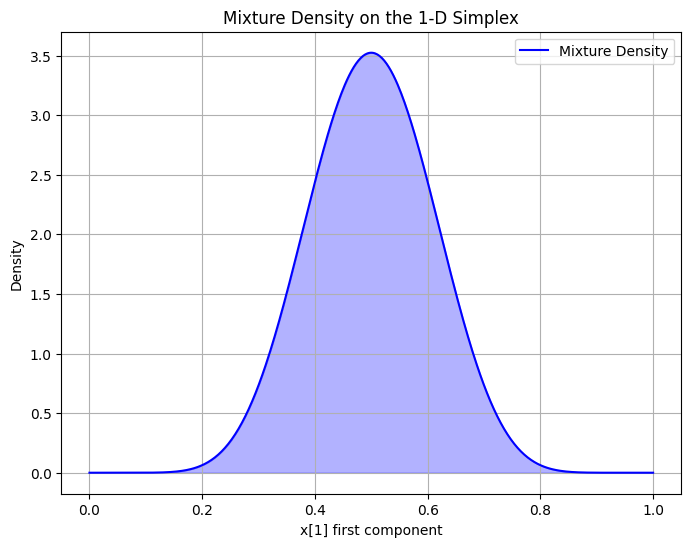

In [3]:
import MLExtreme as mlx

# Example RV-dirimix  data generation p = 2
dimsimp = 2  # Dimensionality of the simplex (2D in this case)
k = 3  # Number of components in the Dirichlet mixture

# Mixture means (Mu), log scale (lnu), and weights (wei)
Mu = np.array([[0.5,0.5], [0.5,0.5], [0.5,0.5]])  # k* p matrix of means
lnu = np.log(20) * np.ones(k)  # log(20) for both components
wei = np.array([1,1,2])  # weights for the mixture components
Mu, wei = mlx.normalize_param_dirimix(Mu, wei)
# inspect the angular density
Mu_wei = wei  @ Mu
# Display the result
mlx.plot_pdf_dirimix_2D(Mu, wei, lnu)

splits_generator = [0.90, 1]
generators = []

# As an adversarial (bulk) angular parameter, use the  center of the simplex
generators.append( 
    lambda n : mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, index_weight_noise=3,
                       Mu_bulk=(np.ones(dimsimp)/dimsimp).reshape(1, dimsimp),
                       wei_bulk=np.ones(1),
                       lnu_bulk=np.ones(1) * np.log(2),
                       size=n).T
)

def unif_simplex(n):
    tmp = np.random.uniform(0,1,n).T
    d = np.random.uniform(0,1,n)
    X = d * np.array( (tmp, 1-tmp) )
    return X

generators.append(unif_simplex)

def generator(n, splits = splits_generator, generators=generators):
    unif = np.random.uniform(0,1,n)
    X = np.zeros((2,n))
    last = 0
    last_n = 0
    
    for split, gen in zip(splits, generators):
        n_tmp = ((unif <= split) & (unif > last)).sum()
        
        X[:,last_n:(last_n+n_tmp)] = gen(n_tmp)

        last_n += n_tmp
        last = split

    return X

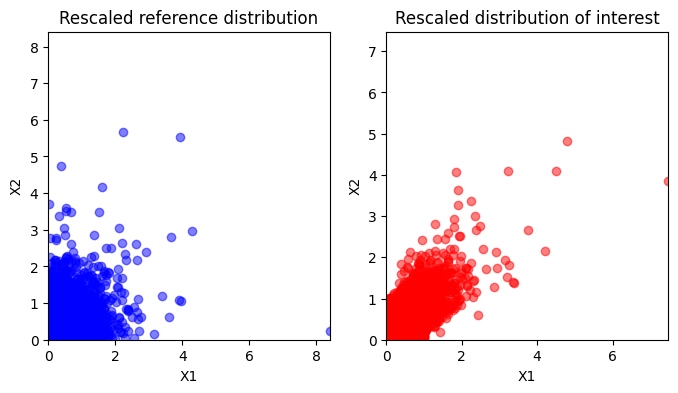

In [4]:
# Generate the datasets
Y = generator(n)
X = generate_reference_data(Y, theta_max = np.pi/2)

# Store original data
X_real, Y_real = X.copy(), Y.copy()

# Normalize data
norm_max = np.sqrt( (Y **2).sum(axis=0) ).max()
X, Y = X/norm_max, Y/norm_max

def rescale(t):
    norms = np.sqrt( ((t)**2).sum(axis=0) )
    dir = t / ( norms + 0.000000001)
    return (norms**(alpha/4)) * dir

X_rescaled = rescale(X_real)
Y_rescaled = rescale(Y_real)
fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 
axs[0].scatter(X_rescaled[0, :], X_rescaled[1, :], color='blue', alpha=0.5)
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
max_range = max(np.max(X_rescaled[0, :]), np.max(X_rescaled[1, :]))
axs[0].set_xlim(0, max_range)
axs[0].set_ylim(0, max_range)
axs[0].set_title('Rescaled reference distribution')
axs[1].scatter(Y_rescaled[0, :], Y_rescaled[1, :], color='red', alpha=0.5)
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
max_range = max(np.max(Y_rescaled[0, :]), np.max(Y_rescaled[1, :]))
axs[1].set_xlim(0, max_range)
axs[1].set_ylim(0, max_range)
axs[1].set_title('Rescaled distribution of interest')
plt.show()


## Estimator function building

We solve the discrete Monge Problem and build the smooth cyclically monotone interpolated transport map proposed in Hallin et al.(2021) and relying on Yosida regularization. The code can be found in $\emph{utils.py}$.

In [5]:
# Solve discrete Monge Problem
C = distmat(X,Y)
LSA = linear_sum_assignment(C)
optimal_assignment = LSA[1]

# Reorder Y so that X[:,i] is sent to Y[:,i]
# by the optimal transport map
Y = Y[:,optimal_assignment]
Y_real = Y_real[:,optimal_assignment]

# Compute the parameters of the estimator
epsilon_star, psi = compute_params(X,Y)

# Build the smooth interpolation of the transport map
T = lambda x : smooth_T(x, Y, epsilon_star, psi, norm_max, lr=epsilon_star/5, steps=3000)

We check the computed solutions.

In [6]:
costs = compute_costs(X, Y)

spread, tmp = check_optimality_cdtn(costs, psi, epsilon_star, epsilon_star)
print( f"Check condition 1: {n*n - tmp.sum()} (should be zero)")
np.sort( spread.flatten() )[:20]

spread_bis, tmp_bis = check_optimality_cdtn_bis(X, Y, psi)
print( f"Check condition 2: {n - tmp_bis.sum()} (should be zero)")

Check condition 1: 0.0 (should be zero)
Check condition 2: 0.0 (should be zero)


## Construction of the learned generator

In [7]:
norms = np.sqrt( np.sum(Y_real**2,axis=0) )
tmpb = norms.copy()
tmpb.sort()
b = tmpb[int(n*(1-p_t))]

In [8]:
def non_extr_generator(n):
    Theta = np.random.uniform(0, np.pi / 2, n)
    unif = np.random.uniform(0, 1-p_t, n)
    inverted_cdf = np.vectorize( lambda q : np.quantile(norms, q, method = "inverted_cdf") )
    rad = inverted_cdf(unif)
    tmp = np.vstack((np.cos(Theta), np.sin(Theta).T)).T
    X = (tmp.T * rad)
    for i in range(n):
        X[:,i] = T(X[:,i])
    return X

# we assume alpha is known
# probably more reasonable to use a known distribution for which we can efficiently
# sample data without needing to estimate alpha
def extr_generator(n):
    Theta = np.random.uniform(0, np.pi / 2, n)
    Unif = np.random.uniform(0, 1, n)
    Pareto = Unif**(-1/alpha)
    tmp = np.vstack((np.cos(Theta), np.sin(Theta).T)).T
    X = (tmp.T * Pareto)
    norms_tmp = np.sqrt( np.sum(X**2,axis=0) )
    # we use homogeneity to apply the estimated tail transport plan only 
    # to points on the unit sphere for which we expect the estimation to be
    # relevant
    X = X / norms_tmp
    for i in range(n):
            X[:,i] = T(b * X[:,i]) / b
    return b * X * norms_tmp

def learned_generator(n, splits = [p_t,1], generators=[extr_generator, non_extr_generator]):
    unif = np.random.uniform(0,1,n)
    X = np.zeros((2,n))
    last = 0
    last_n = 0
    
    for split, gen in zip(splits, generators):
        n_tmp = ((unif <= split) & (unif > last)).sum()
        
        X[:,last_n:(last_n+n_tmp)] = gen(n_tmp)

        last_n += n_tmp
        last = split

    return X

## Generation of new points

We generate two new samples of size $N=10000$, one with the learned generator and one using the true generator.

In [9]:
np.random.seed(42)
N = 10000
generated_points = learned_generator(N)
new_Y = generator(N)

/Users/alexandremansire/Documents/EVT_stage/stagem2/numerics/utils.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_0 = torch.tensor( x.clone().detach(), dtype=torch.float64, requires_grad=True)
/Users/alexandremansire/Documents/EVT_stage/stagem2/numerics/utils.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_0 = torch.tensor( x.clone().detach(), dtype=torch.float64, requires_grad=True)


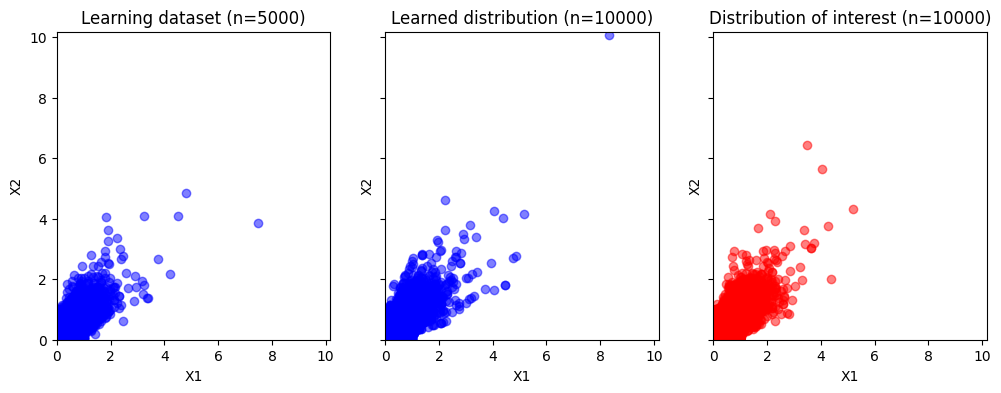

In [17]:
learning_dataset = rescale(Y_real)
generated_rescaled = rescale(generated_points)
Y_rescaled = rescale(generator(N))
fig, axs = plt.subplots(1, 3, figsize=(12, 4),sharex=True, sharey=True) 
axs[0].scatter(learning_dataset[0, :], learning_dataset[1, :], color='blue', alpha=0.5)
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
max_range = max(np.max(learning_dataset[0, :]), np.max(learning_dataset[1, :]))
axs[0].set_title('Learning dataset (n=5000)')
axs[1].scatter(generated_rescaled[0, :], generated_rescaled[1, :], color='blue', alpha=0.5)
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
max_range = max(max_range, np.max(generated_rescaled[0, :]), np.max(generated_rescaled[1, :]))
axs[1].set_title('Learned distribution (n=10000)')
axs[2].scatter(Y_rescaled[0, :], Y_rescaled[1, :], color='red', alpha=0.5)
axs[2].set_xlabel('X1')
axs[2].set_ylabel('X2')
max_range = max(max_range, np.max(Y_rescaled[0, :]), np.max(Y_rescaled[1, :]))
axs[2].set_xlim(0, max_range+0.1)
axs[2].set_ylim(0, max_range+0.1)
axs[2].set_title('Distribution of interest (n=10000)')
plt.show()

## Conclusion

Although further validation of the generated samples is necessary, the method presented in this notebook visually demonstrates promising capabilities in handling regions of the space where extreme values occur and seems to successfully extrapolates distributions in these regions. Indeed, notice in the plot that the method was even able to generate a point far away in the tail of the distribution while the data used to learn the generator contained in the square $[0,8]\times[0,8]$.

By design, points generated within the center-outward quantile regions (used to split the orthant in two) are obtained through conventional means using the estimated transport map. Consequently, future validation efforts can focus specifically on assessing the quality of points generated in the extreme regions (outside the quantile region). 

This work represents an important initial step toward developing a comprehensive understanding of extreme value handling in generative modeling based on optimal transport.